# Bibliotecas

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap, BoundaryNorm

# Modelo VAE

In [4]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) implementation in PyTorch.

    Attributes:
        enc_layer1 (nn.Linear): First layer of the encoder.
        enc_layer2_mu (nn.Linear): Second layer of the encoder for mean.
        enc_layer2_logvar (nn.Linear): Second layer of the encoder for log variance.
        dec_layer1 (nn.Linear): First layer of the decoder.
        dec_layer2 (nn.Linear): Second layer of the decoder.
    """

    def __init__(self, x_dim, hidden_dim, z_dim=10):
        """
        Initializes the VAE model with the given dimensions.

        Args:
            x_dim (int): Dimensionality of the input data.
            hidden_dim (int): Dimensionality of the hidden layer.
            z_dim (int): Dimensionality of the latent space.
        """
        super(VAE, self).__init__()

        # Define autoencoding layers
        self.enc_layer1 = nn.Linear(x_dim, hidden_dim)
        self.enc_layer2_mu = nn.Linear(hidden_dim, z_dim)
        self.enc_layer2_logvar = nn.Linear(hidden_dim, z_dim)

        # Define autoencoding layers
        self.dec_layer1 = nn.Linear(z_dim, hidden_dim)
        self.dec_layer2 = nn.Linear(hidden_dim, x_dim)

    def encoder(self, x):
        """
        Encodes the input data into the latent space.

        Args:
            x (torch.Tensor): Input data.

        Returns:
            torch.Tensor: Mean of the latent space.
            torch.Tensor: Log variance of the latent space.
        """
        x = F.relu(self.enc_layer1(x))
        mu = self.enc_layer2_mu(x)
        logvar = self.enc_layer2_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Reparameterizes the latent space using the mean and log variance.

        Args:
            mu (torch.Tensor): Mean of the latent space.
            logvar (torch.Tensor): Log variance of the latent space.

        Returns:
            torch.Tensor: Reparameterized latent variable.
        """
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z

    def decoder(self, z):
        """
        Decodes the latent variable back into the data space.

        Args:
            z (torch.Tensor): Latent variable.

        Returns:
            torch.Tensor: Reconstructed data.
        """
        output = F.relu(self.dec_layer1(z))
        output = torch.sigmoid(self.dec_layer2(output))
        return output

    def forward(self, x):
        """
        Forward pass through the VAE.

        Args:
            x (torch.Tensor): Input data.

        Returns:
            torch.Tensor: Reconstructed data.
            torch.Tensor: Latent variable.
            torch.Tensor: Mean of the latent space.
            torch.Tensor: Log variance of the latent space.
        """
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        output = self.decoder(z)
        return output, z, mu, logvar

    def loss_function(self, output, x, mu, logvar):
        """
        Computes the loss function for the VAE.

        Args:
            output (torch.Tensor): Reconstructed data.
            x (torch.Tensor): Input data.
            mu (torch.Tensor): Mean of the latent space.
            logvar (torch.Tensor): Log variance of the latent space.

        Returns:
            torch.Tensor: Total loss (reconstruction loss + KL divergence).
        """
        recon_loss = F.binary_cross_entropy(output, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_loss


# Treinamento

In [5]:
def train_model(X_train, X_val, learning_rate=1e-4, batch_size=128, num_epochs=15, hidden_dim=256, latent_dim=50):
    """
    Train a Variational Autoencoder (VAE) model on the provided training dataset and validate it on the validation dataset.

    Parameters:
    X_train (numpy.ndarray): Training data.
    X_val (numpy.ndarray): Validation data.
    learning_rate (float): Learning rate for the optimizer.
    batch_size (int): Batch size for training.
    num_epochs (int): Number of training epochs.
    hidden_dim (int): Dimension of the hidden layer.
    latent_dim (int): Dimension of the latent space.

    Returns:
    model (VAE): Trained VAE model.
    train_losses (list): List of training losses per epoch.
    val_losses (list): List of validation losses per epoch.
    """
    model = VAE(x_dim=X_train.shape[1], hidden_dim=hidden_dim, z_dim=latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_dataset = TensorDataset(torch.tensor(X_train).float())
    val_dataset = TensorDataset(torch.tensor(X_val).float())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            x = batch[0]
            output, z, mu, logvar = model(x)
            loss = model.loss_function(output, x, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader.dataset))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0]
                output, z, mu, logvar = model(x)
                loss = model.loss_function(output, x, mu, logvar)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader.dataset))

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_loader.dataset)}, Val Loss: {val_loss / len(val_loader.dataset)}")

    return model, train_losses, val_losses

# Visualização

In [6]:
def plot_losses(train_losses, val_losses):
    """
    Plot the training and validation losses over epochs.

    Parameters:
    train_losses (list): List of training losses per epoch.
    val_losses (list): List of validation losses per epoch.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_reconstructions(model, data, num_images=10):
    """
    Plot the original and reconstructed images using the trained VAE model.

    Parameters:
    model (VAE): Trained VAE model.
    data (numpy.ndarray): Data to reconstruct.
    num_images (int): Number of images to display.
    """
    model.eval()
    with torch.no_grad():
        data = torch.tensor(data).float()
        output, _, _, _ = model(data)
    fig, axes = plt.subplots(nrows=2, ncols=num_images, sharex=True, sharey=True, figsize=(20, 4))
    fig.suptitle('Dado (Original) vs Predito (Reconstruído)', fontsize=16)
    for i, (images, row, title) in enumerate(zip([data, output], axes, ['Dado', 'Predito'])):
        for img, ax in zip(images, row):
            ax.imshow(img.view(28, 28).numpy(), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        row[0].set_ylabel(title, size='large')
    plt.show()

def plot_latent_space(model, data, labels, num_components=2):
    """
    Plots the latent space representation of the given data using PCA,
    with points colored according to their labels.

    Parameters:
    model (torch.nn.Module): The trained model with an encoder that produces latent representations.
    data (numpy.ndarray): The input data to be transformed and plotted.
    labels (list or numpy.ndarray): The labels corresponding to the input data points.
    num_components (int): The number of principal components to consider for PCA (default is 2).

    Returns:
    None
    """
    model.eval()
    with torch.no_grad():
        data = torch.tensor(data).float()
        mu, logvar = model.encoder(data)
        z = model.reparameterize(mu, logvar)

    # PCA transformation
    pca = PCA(n_components=num_components)
    z_pca = pca.fit_transform(z.numpy())


    # Create a discrete colormap
    cmap = ListedColormap(sns.color_palette("Set3", 10))
    norm = BoundaryNorm(np.arange(-0.5, 10, 1), cmap.N)

    # Plotting the PCA components
    plt.figure(figsize=(12, 6))

    # Plot with original labels
    scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=labels, cmap=cmap, alpha=0.8)


    # Add discrete colorbar
    cbar = plt.colorbar(scatter, ticks=np.arange(10), spacing='proportional')
    cbar.set_label('Label', fontsize=14)

    plt.title('Latent Space Representation with PCA', fontsize=20)
    plt.xlabel('PCA Component 1', fontsize=18)
    plt.ylabel('PCA Component 2', fontsize=18)
    plt.show()


# Definição dos hiperpâmetros e treinamento

Dados de treino (80% treino | 20% validação)
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
               Lambda()
           )
Dados de teste
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
               Lambda()
           )
Epoch 1/20, Train Loss: 248.6109255533854, Val Loss: 193.42872919921874
Epoch 2/20, Train Loss: 178.77158059895834, Val Loss: 168.9013133138021
Epoch 3/20, Train Loss: 163.04016953125, Val Loss: 157.8176785970052
Epoch 4/20, Train Loss: 153.86642220052084, Val Loss: 150.14624744466147
Epoch 5/20, Train Loss: 147.14671704101562, Val Loss: 144.41950592447915
Epoch 6/20, Train Loss: 142.2294119466146, Val Loss: 140.19582057291666
Epoch 7/20, Train Loss

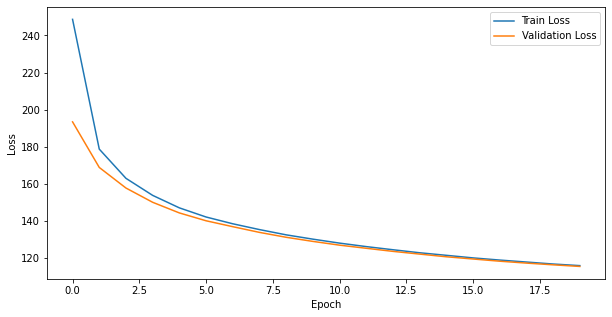

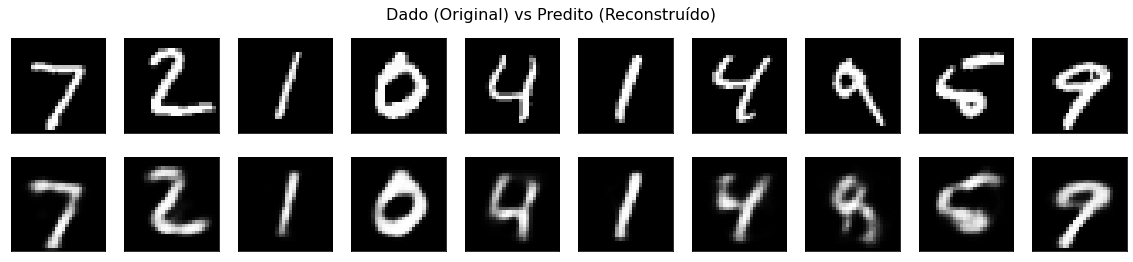

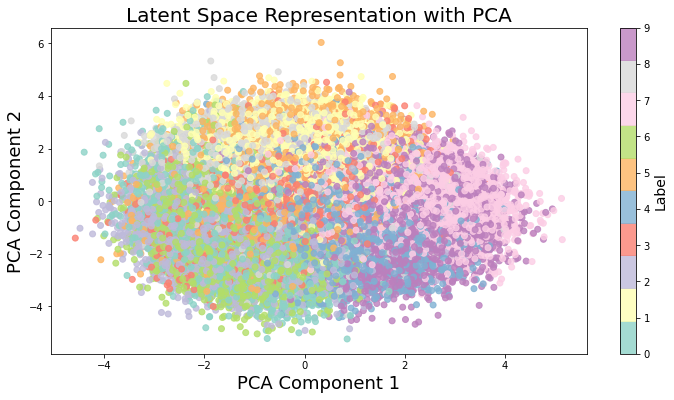

In [7]:
if __name__=='__main__':
    n_imgs=10

    learning_rate=1e-4
    batch_size=128
    num_epochs=20
    hidden_dim=500
    latent_dim=100

    # Carregar o dataset MNIST com transformações
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.Lambda(lambda x: x.view(-1))
    ])

    mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    print('Dados de treino (80% treino | 20% validação)')
    print(mnist_train)

    print('Dados de teste')
    print(mnist_test)

    X_train_full = mnist_train.data.float() / 255.0
    X_train_full = X_train_full.view(X_train_full.size(0), -1)
    X_test = mnist_test.data.float() / 255.0
    X_test = X_test.view(X_test.size(0), -1)

    train_size = int(0.8 * len(X_train_full))
    val_size = len(X_train_full) - train_size
    X_train, X_val = random_split(X_train_full, [train_size, val_size])

    vae_model, train_losses, val_losses = train_model(
        X_train=X_train.dataset.numpy(),
        X_val=X_val.dataset.numpy(),
        learning_rate=learning_rate,
        batch_size=batch_size,
        num_epochs=num_epochs,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim
    )

    print(vae_model)

    plot_losses(train_losses, val_losses)

    plot_reconstructions(vae_model, X_test[:n_imgs].numpy(), num_images=n_imgs)

    y_train_full = mnist_train.targets
    plot_latent_space(vae_model, X_train.dataset.numpy(), y_train_full.numpy(), num_components=latent_dim)